<img src=../images/generic.png width=1200 margin=0px>

---

# UC-3 Certificate Issuance
---

## Business Value of Capability
 * Use Vault as a Certificate Authority
 * Generate certs using apis for applications to enable TLS

### Prerequisites
* Running Vault Enterprise instance (even in dev mode)

<img src=attachment:image.png width=1000>
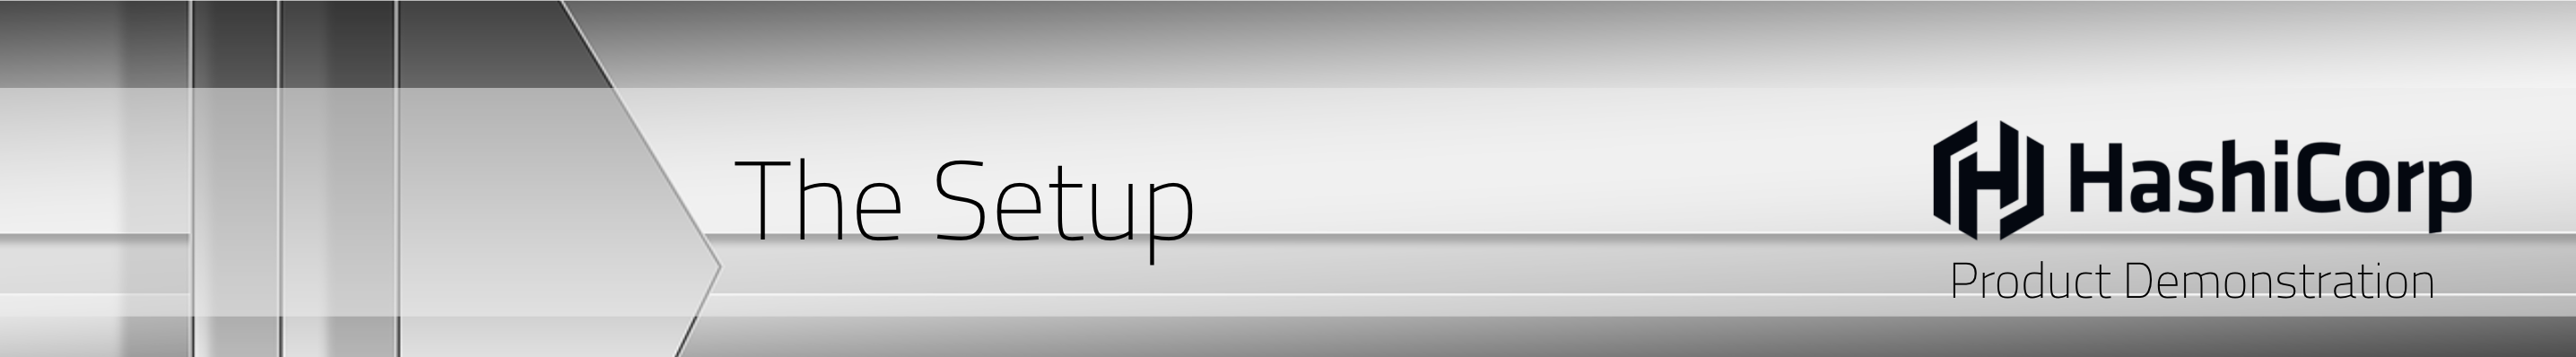

In [ ]:
export WORKDIR=$(pwd)
export VAULT_ADDR=http://127.0.0.1:8200
export VAULT_TOKEN=root
export VAULT_SKIP_VERIFY=true
export LICENSE=/Users/jnyika/.licenses/vault.json
echo $WORKDIR

In [ ]:
#cert directory
mkdir -p $WORKDIR/certs

In [ ]:
vault login root

In [ ]:
vault status

In [ ]:
vault -version

In [ ]:
#license
curl \
  --header "X-Vault-Token: root" \
  --request PUT \
  --data "@${LICENSE}" \
  http://127.0.0.1:8200/v1/sys/license

<img src= attachment:image.png width=1000>
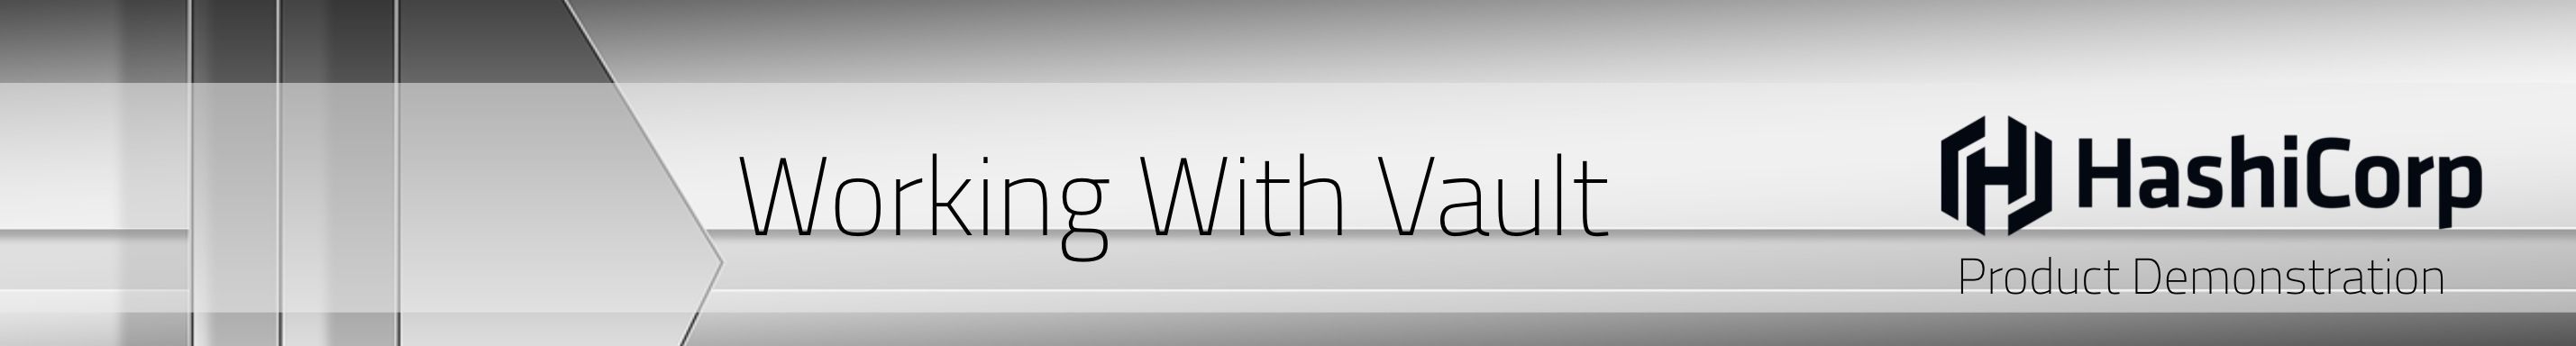

### Demo
---

### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Enable the PKI Secrets Engine</span>

In [ ]:
vault secrets enable -path=pki-root pki

**Tune the maximum length of a cert lease**

In [ ]:
vault secrets tune -max-lease-ttl=8760h pki-root

**Generate an Internal CA & Certs**

### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Method 1: Vault Generates Self Signed CA and Private Key </span>

### You can also have Vault use an intermediary CA using the /pki/intermediate/generate/ endpoint
```bash 
vault write pki/intermediate/generate/internal common_name=cloud.annexos.com  data=@pem_bundle.json
```

or you can have Vault **set an PEM encoded certificate and private key bundle, use the pki/config/ca endpoint

```bash
vault write pki/config/ca pem_bundle=@pem_bundle.json
```
## NOTE: Only one CA certificate is allowed per secrets engine
If you want more, mount the engine at multiple paths and assign a new CA at each.

In [ ]:
vault write -format=json pki-root/root/generate/internal \
    common_name=*.annexos.com \
    format=pem_bundle
    ttl=8760h > $WORKDIR/certs/root_pem_bundle.json

### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Update the Certificate Revocation List</span>

**Update URLs for the CA issuer and CRL**

In [ ]:
vault write pki-root/config/urls \
    issuing_certificates="http://127.0.0.1:8200/v1/pki-root/ca" \
    crl_distribution_points="http://127.0.0.1:8200/v1/pki-root/crl"

### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Configure Role for Issuing Certs</span>

**Configure role**
Generating certificates requires you to supply a role. The role definition sets the conditions under which a certificate can be generated.

In [ ]:
vault write pki-root/roles/Role-annexos \
    allowed_domains=project.annexos.com \
    allow_subdomains=true \
    max_ttl=72h

### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Example Issue Request</span>

**Issue request**

In [ ]:
vault write pki-root/issue/Role-annexos \
    common_name=*.project.annexos.com

### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Example Rotate CRL Request</span>

In [ ]:
vault read pki-root/crl/rotate

### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Example Revoke Certificate Request</span>

### you can also tidy up the CRL over time
```
vault write pki/tidy tidy_cert_store=true tidy_revoked_certs=true
```

In [ ]:
vault write pki-root/revoke \
serial_number=0e:4b:ed:0b:07:b5:a8:81:f7:5c:ab:b0:da:05:bf:3d:31:75:35:e4

In [ ]:
vault secrets disable pki-root

**END**

<img src=attachment:image.png width=1000>

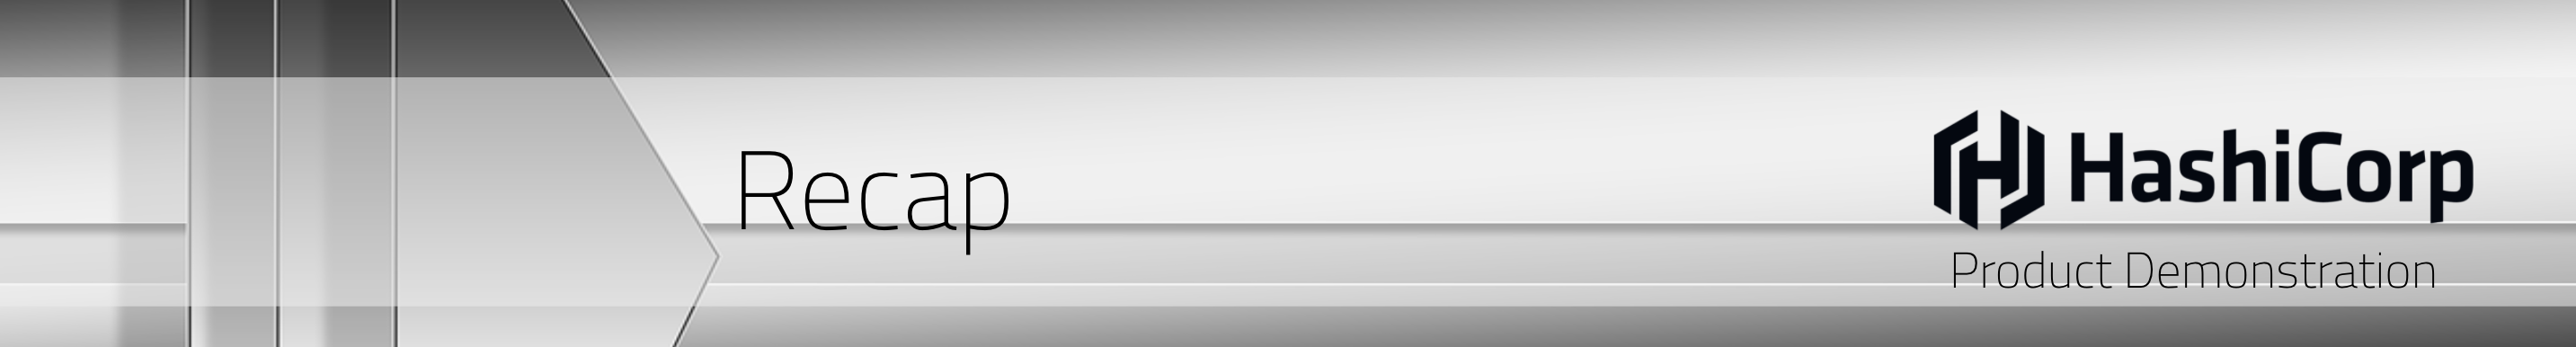

* ## <span style="color: #001f3f; padding: 15px; border-radius: 2px">Configure A Cert Authority</span>
* ## <span style="color: #001f3f; padding: 15px; border-radius: 2px">Tune Certificate times and update CRLs</span>
* ## <span style="color: #001f3f; padding: 15px; border-radius: 2px">Give users an easy way to request certs</span>
